In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import itertools
import pickle


from activations import *
import train_integers

%matplotlib notebook
%load_ext autoreload
%autoreload 2


def save_object(data, filename):
    with open(filename, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)
        
        
def load_object(filename):
    try:
        with open(filename, 'rb') as input:
            return pickle.load(input)
    except Exception as err: 
        print err
        return None
    

# button for hiding code
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



## We are interested in how the fraction bitwidth and the learning rate impact network training. 

### We investigate if training on fixed point values is possible.
If so, we ask:
* What is the minimum precision needed for training?
* How does the precision affect accuracy?
* Do learning rates depend on precision, and how much? Does the conventional floating point knowledge apply here?

### We will test a grid search of both of these parameters and plot the achieved precision after a fixed number of iterations on several different datasets.

<IPython.core.display.Javascript object>


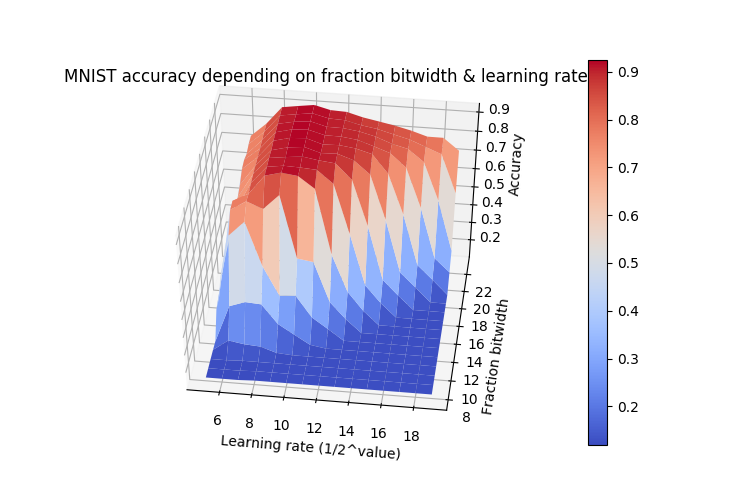

In [3]:
from sklearn.datasets import load_digits, fetch_mldata
# digits = load_digits()
# inputs  = digits['data'] / 16.0
# targets = digits['target']

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

mnist_acc = load_object("mnist_accuracies.pickle")
if mnist_acc is not None:
    accuracies, learning_rates, fractions = mnist_acc
if mnist_acc is None: 
    accuracies = np.zeros((20 - 5, 24 - 8))
    learning_rates = np.zeros((20 - 5, 24 - 8))
    fractions = np.zeros((20 - 5, 24 - 8))
    for lr in range(5, 20):
        for fraction in range(8, 24):
            print("Fraction {}, LR {}".format(fraction, lr))
            acc = train_integers.test_classification(inputs, targets, fraction=fraction, lr=lr, 
                      conf=[784, 10], iter=10000, smooth_window=1001, func=relu, 
                      func_der=relu_derivative, verbosity="none")
            accuracies[lr - 5, fraction - 8] = acc[-1]
            learning_rates[lr - 5, fraction - 8] = lr
            fractions[lr - 5, fraction - 8] = fraction
    
    save_object((accuracies, learning_rates, fractions), "mnist_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111, projection='3d')
surface = ax1.plot_surface(learning_rates, fractions, accuracies, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_zlabel("Accuracy")
ax1.set_title("MNIST accuracy depending on fraction bitwidth & learning rate")

cbar = fig.colorbar(surface)


## As we can see, there are 2 cliffs on this accuracy plot:
* The first (left) cliff shows that the learning rate cannot be too high, no matter the fraction bitwidth
* The second (diagonal) cliff shows that the smaller the learning rate, the more we require precision or otherwise the updates will not modify the quantized weights

## We can conclude from this graph that:
* After a certain amount of precision, adding more bits **does not** improve precision
* Learning rate needs to grow proportionally (exponentially?) with bitwidth. Too low of a learning rate destroys the signal. 

## Let's test it out on the DIGITS dataset too

<IPython.core.display.Javascript object>


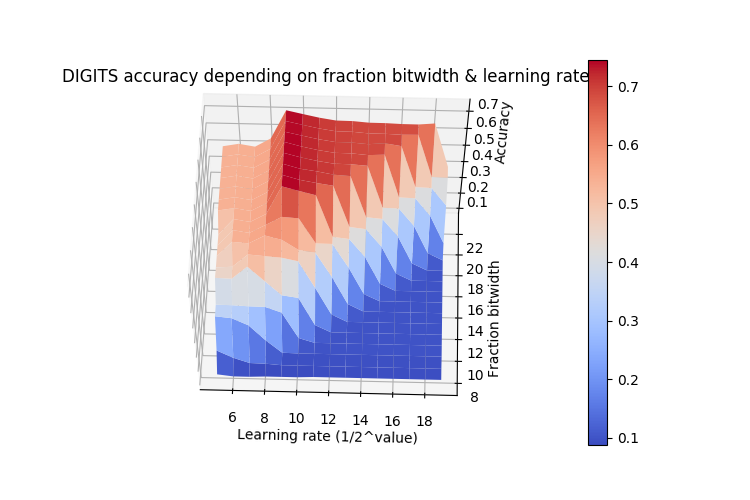

In [9]:
from sklearn.datasets import load_digits, fetch_mldata
digits = load_digits()
inputs  = digits['data'] / 16.0
targets = digits['target']

digits_acc = load_object("digits_accuracies.pickle")
if digits_acc is not None:
    accuracies, learning_rates, fractions = digits_acc
if digits_acc is None: 
    accuracies = np.zeros((20 - 5, 24 - 8))
    learning_rates = np.zeros((20 - 5, 24 - 8))
    fractions = np.zeros((20 - 5, 24 - 8))
    for lr in range(5, 20):
        for fraction in range(8, 24):
            print("Fraction {}, LR {}".format(fraction, lr))
            acc = train_integers.test_classification(inputs, targets, fraction=fraction, lr=lr, 
                      conf=[64, 10], iter=10000, smooth_window=1001, func=relu, 
                      func_der=relu_derivative, verbosity="none")
            accuracies[lr - 5, fraction - 8] = acc[-1]
            learning_rates[lr - 5, fraction - 8] = lr
            fractions[lr - 5, fraction - 8] = fraction
    
    save_object((accuracies, learning_rates, fractions), "digits_accuracies.pickle")

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111, projection='3d')
surface = ax1.plot_surface(learning_rates, fractions, accuracies, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_zlabel("Accuracy")
ax1.set_title("DIGITS accuracy depending on fraction bitwidth & learning rate")

cbar = fig.colorbar(surface)


### Again, we see a similar behavior. 
While smaller learning rates work, it seems that there is cliff where the learning rate $\frac{1}{2^9} \tilde= 0.002$ yields the best results. This is similar to reported results in literature, with learning rate ranging from 0.01 to 0.001. It looks like it is independent of the bitwidth, pointing to the fact that there is no reason to add more than 16 bits for the fractional part.

# Let's try and quantify the cliffs

<IPython.core.display.Javascript object>


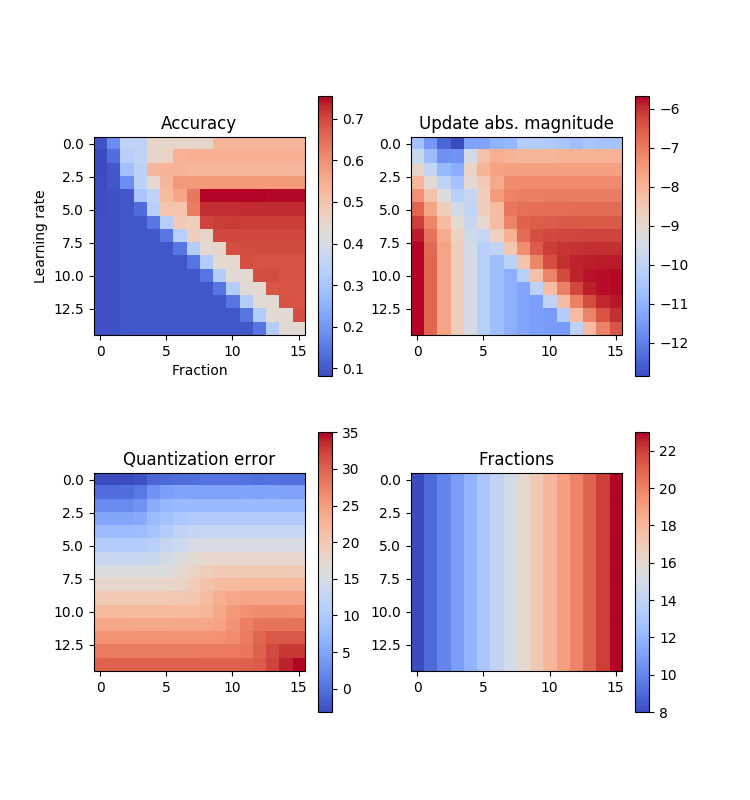

In [11]:
from sklearn.datasets import load_digits, fetch_mldata

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

avg_update = load_object("avg_update.pickle")
if avg_update is not None:
    updates, errors, learning_rates, fractions = avg_update
else: 
    updates = np.zeros((20 - 5, 24 - 8))
    errors = np.zeros((20 - 5, 24 - 8))
    learning_rates = np.zeros((20 - 5, 24 - 8))
    fractions = np.zeros((20 - 5, 24 - 8))
    for lr in range(5, 20):
        for fraction in range(8, 24):
            print("Fraction {}, LR {}".format(fraction, lr))
            val = train_integers.test_classification_save_values(inputs, targets, fraction=fraction, lr=lr, 
                      conf=[784, 10], iter=10000, smooth_window=1001, func=relu, 
                      func_der=relu_derivative, verbosity="none")
            avg_update = np.mean(np.abs(val[5]))
            avg_error  = np.mean(np.abs(val[5] - val[6] * 2**lr) * 2**fraction)
            updates[lr - 5, fraction - 8] = avg_update
            errors[lr - 5, fraction - 8] = avg_error
            learning_rates[lr - 5, fraction - 8] = lr
            fractions[lr - 5, fraction - 8] = fraction
    
    save_object((updates, errors, learning_rates, fractions), "avg_update.pickle")

fig = plt.figure(figsize=(7.5, 8))
plt.subplot(221)
plt.imshow(accuracies, cmap=cm.coolwarm)
plt.colorbar()
plt.title("Accuracy")
plt.xlabel("Fraction")
plt.ylabel("Learning rate")

plt.subplot(222)
plt.imshow(np.log2(updates / 2.0**fractions), cmap=cm.coolwarm)
plt.colorbar()
plt.title("Update abs. magnitude")

plt.subplot(223)
plt.imshow(np.log2(errors * 2.0**(learning_rates - fractions)), cmap=cm.coolwarm)
plt.colorbar()
plt.title("Quantization error")

plt.subplot(224)
plt.imshow(fractions, cmap=cm.coolwarm)
plt.colorbar()
plt.title("Fractions")

